In [1]:
pip install path.py


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import os, gc
import urllib.request
import random
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import shutil as sl
from tqdm import tqdm
import path as Path
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.optim as optim
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 
from IPython.display import display

from torchmetrics.detection import IntersectionOverUnion
from torch import tensor

from torch.utils.data import WeightedRandomSampler, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Image as Image_IP
from IPython.display import clear_output
from torchmetrics import Accuracy
from torchmetrics.detection.mean_ap import MeanAveragePrecision



In [3]:
NUM_FILES = 500

In [4]:
import os
import shutil as sl
import glob
from tqdm import tqdm

# Define paths
PATH_DIR = "C:\\Users\\Adnan\\Downloads\\archive\\VOC2012\\VOC2012"
PATH_ANN = 'C:\\Users\\Adnan\\Downloads\\archive\\VOC2012\\VOC2012\\Annotations'
PATH_IMG = 'C:\\Users\\Adnan\\Downloads\\archive\\VOC2012\\VOC2012\\JPEGImages'
PATH_WORK = 'C:\\Users\\Adnan\\Downloads'
TARGET_DIR = os.path.join(PATH_WORK, "voc2010")

# Remove the existing 'voc2010' directory if it exists
if os.path.isdir(TARGET_DIR):
    sl.rmtree(TARGET_DIR)

# Create necessary directories if they don't exist
if not os.path.isdir(TARGET_DIR):
    os.makedirs(os.path.join(TARGET_DIR, "annotations"))
    os.makedirs(os.path.join(TARGET_DIR, "images"))

# Number of files to process (adjust as needed)
NUM_FILES = 500  # Replace with the desired number of files

# Copy annotation files and corresponding images
i = 0
for xml_file in tqdm(sorted(glob.glob(os.path.join(PATH_ANN, '2010*.xml')))):
    if i < NUM_FILES:
        i += 1
    else:
        break
    # Copy annotation file
    sl.copy(xml_file, os.path.join(TARGET_DIR, "annotations"))

    # Construct the corresponding image file path
    img_file = os.path.join(PATH_IMG, os.path.basename(xml_file)[:-4] + ".jpg")
    
    # Check if the image file exists before copying
    if os.path.isfile(img_file):
        sl.copy(img_file, os.path.join(TARGET_DIR, "images"))
    else:
        print(f"Image file not found: {img_file}")


 14%|███████████▏                                                                  | 500/3503 [00:01<00:11, 268.39it/s]


In [5]:
BATCH_SIZE = 4

In [6]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

# Function to convert XML files to a CSV
def xml_to_csv(path=PATH_ANN):
    xml_list = []
    # Iterate over all XML files in the given directory
    for xml_file in tqdm(sorted(glob.glob(os.path.join(path, '*.xml')))):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract file information
        file_name = root.find('filename').text
        internal = root.find('size')
        channels = int(internal.find('depth').text) if internal.find('depth') is not None else 0
        width = int(internal.find('width').text)
        height = int(internal.find('height').text)

        # Extract object information from the XML
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbx = obj.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            value = (file_name, name, width, height, xmin, ymin, xmax, ymax)
            xml_list.append(value)

    # Define column names for the DataFrame
    column_name = ['file', 'name', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

# Define paths for annotations and output file
annotations_path = os.path.join(PATH_WORK, 'voc2010', 'annotations')
output_csv_path = os.path.join(PATH_WORK, 'voc2010.csv')

# Convert XML annotations to CSV
xml_df = xml_to_csv(annotations_path)

# Save the DataFrame as a CSV file
xml_df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to: {output_csv_path}")

# Clean up
del xml_df


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2727.28it/s]


CSV file saved to: C:\Users\Adnan\Downloads\voc2010.csv


In [7]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = 'C:\\Users\\Adnan\\Downloads\\voc2010.csv'
df_voc = pd.read_csv(csv_file_path)

# Display the first 5 rows of the DataFrame
print(df_voc.head(5))

# Print additional information about the data
print("Number of objects:", len(df_voc))
print("Number of unique images:", len(df_voc['file'].unique()))


              file         name  width  height  xmin  ymin  xmax  ymax
0  2010_000001.jpg          cat    500     333   123    13   341   313
1  2010_000001.jpg        chair    500     333   294    13   410   236
2  2010_000001.jpg        chair    500     333   418   198   500   290
3  2010_000001.jpg        chair    500     333   362     1   498    80
4  2010_000001.jpg  diningtable    500     333     1   219   500   333
Number of objects: 1136
Number of unique images: 500


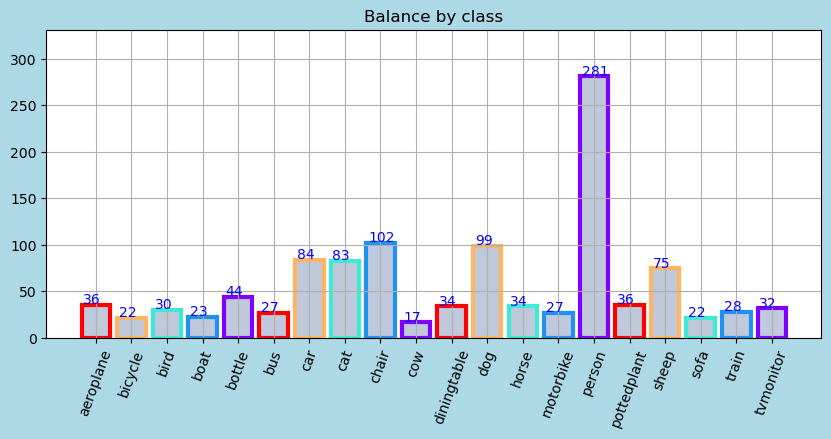

In [8]:
grp_class = df_voc.groupby('name')['xmin'].count()

grp_class = df_voc.groupby('name').count()['xmin']
colors = ['#FF0000','#FEB562','#3DEAD5','#1E91F3','#8000FF']
fig, ax = plt.subplots(figsize=(10,4), facecolor='lightblue')

ax.bar(grp_class.index, grp_class, color='#C0C8DB', linewidth=3.0, edgecolor=colors)
for i in range(len(df_voc['name'].unique())):
    ax.text(i-0.35, grp_class.iloc[i]+1, grp_class.iloc[i], color='#0000FF') # +70 all records
plt.xticks(rotation=70)
ax.set_ylim(0, grp_class.max()+round(grp_class.max()/np.log(grp_class.max()), 2))
plt.grid(True)
ax.set_title("Balance by class")
plt.show();

In [9]:
rcnn_cod = {v: (idx + 1) for idx, v in enumerate(sorted(df_voc['name'].unique()))}
df_voc['rcnn_class'] = df_voc['name'].replace(rcnn_cod).astype('int')

# Encoding for YOLO: Assigning class IDs starting from 0
yolo_cod = {v: idx for idx, v in enumerate(sorted(df_voc['name'].unique()))}
df_voc['yolo_class'] = df_voc['name'].replace(yolo_cod).astype('int')

# Display the first 10 rows of the DataFrame
print(df_voc.head(10))

# Preparing class dictionaries for decoding
rcnn_dict = {v: k for k, v in rcnn_cod.items()}
yolo_dict = {v: k for k, v in yolo_cod.items()}

# Print the class dictionaries
print("RCNN Class Dictionary:\n", rcnn_dict, '\n')
print("YOLO Class Dictionary:\n", yolo_dict)

              file         name  width  height  xmin  ymin  xmax  ymax  \
0  2010_000001.jpg          cat    500     333   123    13   341   313   
1  2010_000001.jpg        chair    500     333   294    13   410   236   
2  2010_000001.jpg        chair    500     333   418   198   500   290   
3  2010_000001.jpg        chair    500     333   362     1   498    80   
4  2010_000001.jpg  diningtable    500     333     1   219   500   333   
5  2010_000001.jpg  diningtable    500     333     1     1   234   188   
6  2010_000002.jpg        sheep    500     430   102    46   411   400   
7  2010_000003.jpg          dog    500     375   160   156   344   307   
8  2010_000003.jpg        chair    500     375    17    52   455   375   
9  2010_000009.jpg          cat    500     333   160    30   345   312   

   rcnn_class  yolo_class  
0           8           7  
1           9           8  
2           9           8  
3           9           8  
4          11          10  
5          11    

In [10]:
names, class_counts = np.unique(df_voc['name'], return_counts=True)

# Calculate sample weights for each class based on class frequency
sample_weights = [round(1 - c / sum(class_counts), 5) for c in class_counts]

# Replace class names with their corresponding sample weights
df_voc['weight_f'] = df_voc['name'].replace(dict(zip(names, sample_weights)))

# Average weight per file
df_voc['weight_f'] = df_voc.groupby('file')['weight_f'].transform('mean')

# Create a short string version of the weights (truncated to 3 decimal places as strings)
df_voc['weight_s'] = df_voc['weight_f'].astype(str).apply(lambda x: x[:3])

# Display the first 10 rows of the DataFrame
print(df_voc.head(10))

              file         name  width  height  xmin  ymin  xmax  ymax  \
0  2010_000001.jpg          cat    500     333   123    13   341   313   
1  2010_000001.jpg        chair    500     333   294    13   410   236   
2  2010_000001.jpg        chair    500     333   418   198   500   290   
3  2010_000001.jpg        chair    500     333   362     1   498    80   
4  2010_000001.jpg  diningtable    500     333     1   219   500   333   
5  2010_000001.jpg  diningtable    500     333     1     1   234   188   
6  2010_000002.jpg        sheep    500     430   102    46   411   400   
7  2010_000003.jpg          dog    500     375   160   156   344   307   
8  2010_000003.jpg        chair    500     375    17    52   455   375   
9  2010_000009.jpg          cat    500     333   160    30   345   312   

   rcnn_class  yolo_class  weight_f weight_s  
0           8           7  0.932952      0.9  
1           9           8  0.932952      0.9  
2           9           8  0.932952      0.9

In [11]:
X = df_voc[['file', 'weight_s']].drop_duplicates()
y = X['weight_s']

# Splitting data into train, validation, and test sets
train, test = train_test_split(X, train_size=0.8, stratify=y, random_state=42)
valid, test2 = train_test_split(test, train_size=0.8, random_state=42)

# Creating train, validation, and test DataFrames based on the file names
train_df = df_voc[df_voc['file'].isin(train['file'])].copy()
valid_df = df_voc[df_voc['file'].isin(valid['file'])].copy()
test_df = df_voc[df_voc['file'].isin(test2['file'])].copy()

# Displaying the first 3 rows of each DataFrame
print("Train DataFrame Sample:")
print(train_df.head(3))

print("\nValidation DataFrame Sample:")
print(valid_df.head(3))

print("\nTest DataFrame Sample:")
print(test_df.head(3))

Train DataFrame Sample:
              file   name  width  height  xmin  ymin  xmax  ymax  rcnn_class  \
0  2010_000001.jpg    cat    500     333   123    13   341   313           8   
1  2010_000001.jpg  chair    500     333   294    13   410   236           9   
2  2010_000001.jpg  chair    500     333   418   198   500   290           9   

   yolo_class  weight_f weight_s  
0           7  0.932952      0.9  
1           8  0.932952      0.9  
2           8  0.932952      0.9  

Validation DataFrame Sample:
               file       name  width  height  xmin  ymin  xmax  ymax  \
36  2010_000035.jpg        car    500     319   301     1   500   163   
37  2010_000035.jpg        car    500     319     1     1   134   160   
38  2010_000035.jpg  motorbike    500     319    14     6   486   317   

    rcnn_class  yolo_class  weight_f weight_s  
36           7           6  0.942783      0.9  
37           7           6  0.942783      0.9  
38          14          13  0.942783      0.9  


In [12]:
transforms_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['labels'], min_area=21))

transforms_valid = ToTensorV2()

In [13]:
class VOC_2010(torch.utils.data.Dataset):
    def __init__(self, df, imdir, transforms):
        self.df = df
        self.imdir = imdir
        self.imnames = df['file'].unique()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # Get the image name and construct the path
        imname = self.imnames[idx]
        img_path = os.path.join(self.imdir, imname)

        # Load the image with error handling
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            # Print an error message and raise an exception if the image cannot be loaded
            print(f"Error: Unable to load image. Check if the file exists and is accessible: {img_path}")
            raise FileNotFoundError(f"Image not found or could not be loaded: {img_path}")

        # Convert BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentations (if any)
        mask = self.df['file'] == imname
        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        labels = np.array(self.df[mask]['rcnn_class'])
        transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)

        # Prepare outputs for the model
        image = transformed['image']
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)  # Use float32 for better precision
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': bboxes, 'labels': labels}

        # Normalize image
        image = image / 255.0

        return image, target
    
    
    def __len__(self):
        return len(self.imnames)

In [14]:
img_dir = "C:\\Users\\Adnan\\Downloads\\voc2010\\images"

train_data = VOC_2010(train_df, img_dir, transforms_train)
valid_data = VOC_2010(valid_df, img_dir, transforms_valid)



print('Training sample size', len(train_data))
print('Validation sample size', len(valid_data))

Training sample size 400
Validation sample size 80


In [15]:
train_whs = torch.as_tensor(np.array(train_df.drop_duplicates(subset='file')['weight_f']), dtype=torch.float16)

valid_whs = torch.as_tensor(np.array(valid_df.drop_duplicates(subset='file')['weight_f']), dtype=torch.float16)

train_sampler = WeightedRandomSampler(train_whs, len(train_whs))
valid_sampler = WeightedRandomSampler(valid_whs, len(valid_whs))

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
    train_data, 
    sampler=train_sampler, 
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
    )

valid_dataloader = DataLoader(
    valid_data, 
    sampler=valid_sampler, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
    )

# DataLoader for measuring metrics.  
metrics_dataloader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

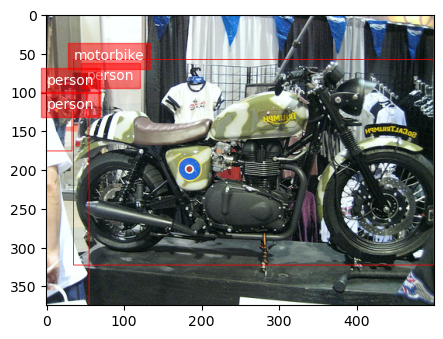

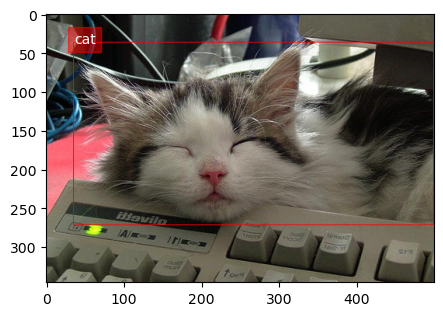

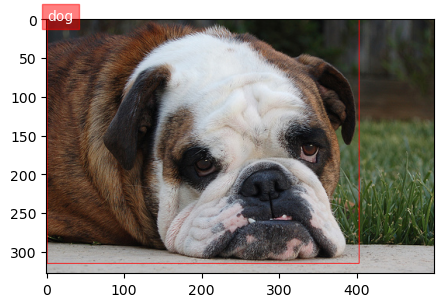

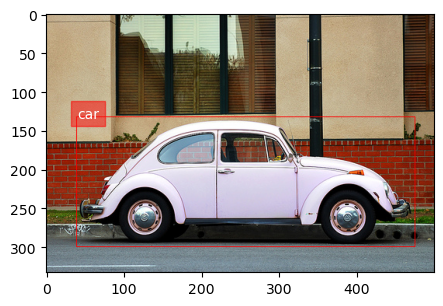

In [17]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data):
    img = next(iter(data))
    for num in range(BATCH_SIZE):
        image = image_convert(img[0][num])
        image = np.ascontiguousarray(image)
        bboxes = img[1][num]['boxes'].numpy()
        labels = img[1][num]['labels']
        fig, ax = plt.subplots(figsize=(5,5))
        
        for i, bbox in enumerate(bboxes):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=1)
            text = ax.text(xmin, ymin, f'{rcnn_dict[int(str(labels[i])[7:-1])]}', fontsize=10, color='w')
            text.set_bbox(dict(facecolor='r', alpha=0.5, edgecolor='r'))
        plt.imshow(image);
    
plot_img(train_dataloader)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We use a pre-trained Resnet-50 model.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = len(class_counts)

# Let's get the number of input features for the classifier.
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Let's replace the classifier with a new one.
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
print(f'\nDevice: {device}, number of classes: {num_classes}, pretrained model: Resnet-50')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Adnan/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:04<00:00, 37.3MB/s]



Device: cpu, number of classes: 20, pretrained model: Resnet-50


In [19]:
def calc(model, optimizer, dataloader, scheduler):
    scheduler = scheduler
    model.train()
    def sub_calc(dataloader, scheduler, is_train=True, mode='train'):
        loss, indx = [], 0
        torch.set_grad_enabled(is_train)
    
        for i, (images, targets) in tqdm(enumerate(dataloader)):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss.append(losses.item())
            if is_train:
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
        scheduler.step() if is_train else scheduler
        return round(np.mean(loss), 4)
    return sub_calc(train_dataloader, scheduler, True, 'train'), sub_calc(valid_dataloader, scheduler, False, 'valid')

In [20]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.7, weight_decay=0.0005)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.01,step_size_up=5,mode="exp_range",gamma=0.85)

In [21]:
num_epochs = 10
total_train_loss = []
total_valid_loss = []
total_epochs = []
best_model = 1000
start = datetime.now()
for epoch in range(num_epochs):
    print(f'There is a calculation of {epoch+1} epoch out of {num_epochs}.\
    Please wait...', end='\r')
    train_loss, valid_loss = calc(model, optimizer, train_dataloader, scheduler)
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
    total_epochs.append(epoch+1)
    if valid_loss < best_model:
        best_model = valid_loss
        path_best = f"ep{str(epoch+1)}_best_model.pth"
        torch.save(model.state_dict(), path_best)
    clear_output(wait=True)
    print('')
end = datetime.now()
print("Runtime Faster RCNN:",str(end-start)[:7])


Runtime Faster RCNN: 7:15:31


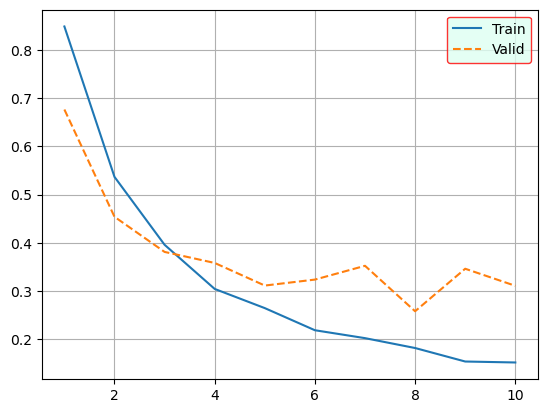

In [22]:
# epoch = range(1,21,1)
plt.plot(total_epochs, total_train_loss, label='Train')
plt.plot(total_epochs, total_valid_loss, label='Valid', linestyle='--')
plt.grid(True)
plt.legend(loc=1, frameon=True, edgecolor='red', facecolor='#DEFFF2')
plt.show();

In [24]:
del model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_classes = len(np.unique(df_voc['rcnn_class'])) 
print(f'num_class: {num_classes}')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
model.load_state_dict(torch.load('C:\\Users\\Adnan\\ep8_best_model.pth'))

cpu
num_class: 20


C:\Users\Adnan\AppData\Local\Temp\ipykernel_17544\4209145008.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:\\Users\\Adnan\\ep8_best

<All keys matched successfully>

In [25]:
PIP_th = 0.5

# Threshold for the non-maximum block suppression filter (torch.nms).  
IOU_th = 0.7

In [26]:
# Function for filtering blocks with a low level of confidence. 
def filt_box(f_data, pip_th):
    data_p = f_data.copy()
    main_lst = []
    
    for idx, val in enumerate(f_data['scores']):
        if val > pip_th:
            main_lst.append(idx)
    for i in list(data_p.keys()):
        data_p[i] = data_p[i][main_lst]
    return data_p

# Function for non-maximum block suppression (Torch.nms).  
def filt_nms(f_data, iou_th):
    main_idx = torchvision.ops.nms(f_data['boxes'], f_data['scores'], iou_th)
    final_pr = f_data

    for i in list(f_data.keys()):
        final_pr[i] = final_pr[i][main_idx]
    return final_pr


# Filtering, prediction and data management function for mAP.  
def proc_p(model, img, pip_th, iou_th, num, images=0):
    if images == 0:
        model = model.to('cpu')
        model.eval()
        with torch.no_grad():
            model_p = model(img[0])
        f_pip = filt_box(model_p[num], pip_th)
        f_pred = filt_nms(f_pip, iou_th)
        return f_pred['boxes'], f_pred['labels'], f_pred['scores']*100
    else:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            model_p = model(images)
        model_p = list({key: val.to('cpu') for key, val in pred.items()} for pred in model_p)
        f_pip = list(filt_box(pred, 0.45) for pred in model_p)
        f_pred = list(filt_nms(pred, 7) for pred in f_pip)
        return f_pred

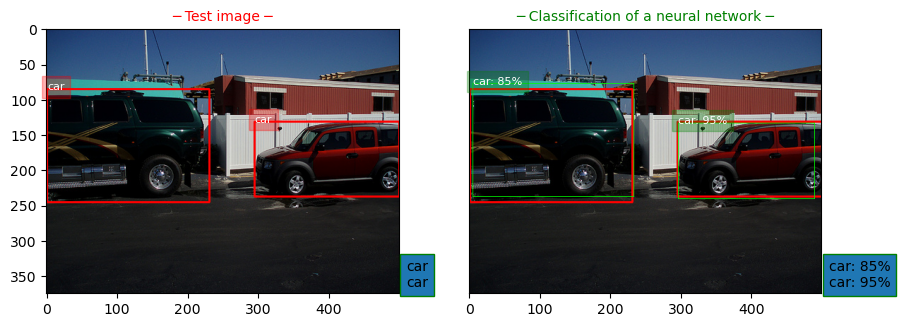

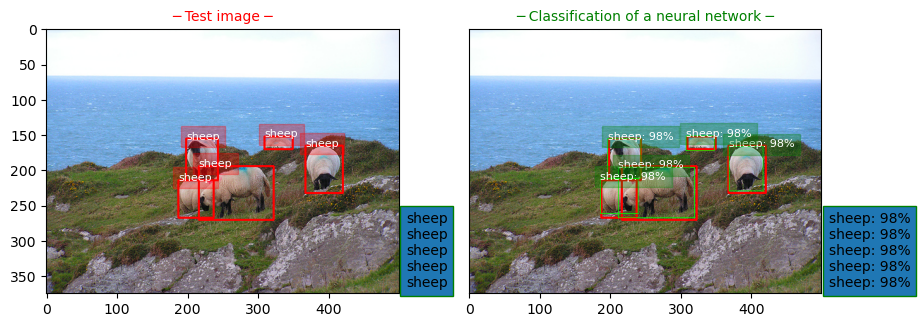

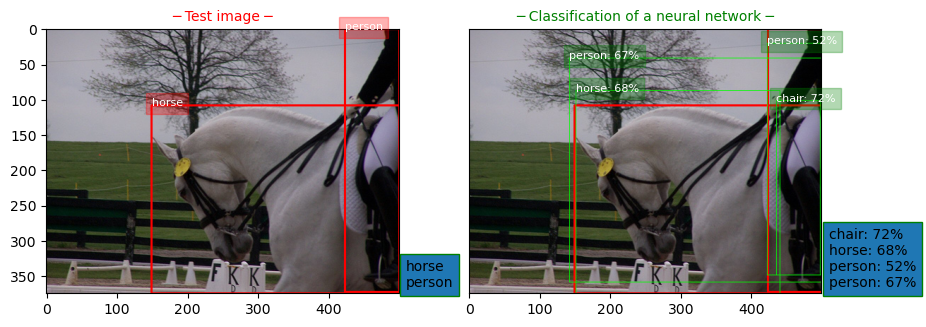

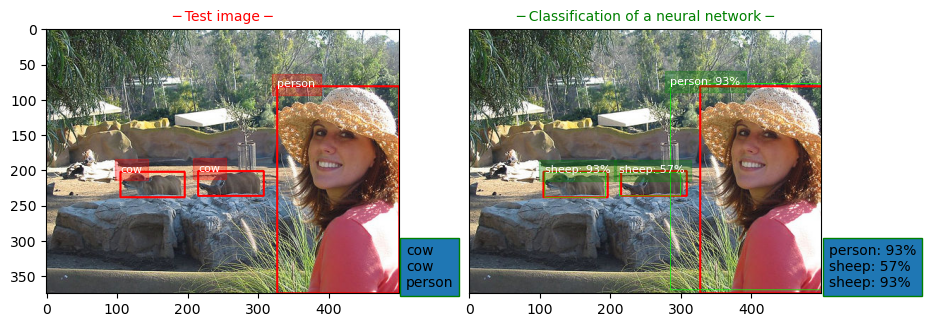

In [27]:
def pict_predict(model,data, batch):
    img = next(iter(data))
    for num in range(batch):
        image = image_convert(img[0][num])
        image = np.ascontiguousarray(image)
        bboxes = img[1][num]['boxes'].numpy()
        labels = img[1][num]['labels']
        bboxes_p, labels_p, scores_p = proc_p(model, img, PIP_th, IOU_th, num, 0)
        iter_box=[]
        iter_box.append(bboxes)
        iter_box.append(bboxes_p)
        fig, axes = plt.subplots(1, 2, figsize=(10,7))
        txt, txt_p = [], []
        
        for n in range(2):
            for i, vol in enumerate(iter_box[n]):
                xmin, ymin, xmax, ymax = (int(vol[0]), int(vol[1]), int(vol[2]), int(vol[3]))
                if n == 0:
                    coler, clr,t_ness = (255,0,0), 'r', 2
                    txt.append(rcnn_dict[int(str(labels[i])[7:-1])])
                    text = axes[n].text(xmin, ymin, f'{rcnn_dict[int(str(labels[i])[7:-1])]}', fontsize=8, color='w')
                if n == 1:
                    coler, clr, t_ness = (0,255,0), 'g', 1
                    txt_p.append(f"{rcnn_dict[int(str(labels_p[i])[7:-1])]}: {int(scores_p[i])}%")
                    text = axes[n].text(xmin, ymin, f'{rcnn_dict[int(str(labels_p[i])[7:-1])]}: {int(scores_p[i])}%', fontsize=8, color='w')
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), coler, thickness=t_ness)
                text.set_bbox(dict(facecolor=clr, alpha=0.3, edgecolor=clr))
                
            x = str(sorted(txt))[1:-1].replace("'", "")
            xn  = x.replace(", ", "\n")
            y = str(sorted(txt_p))[1:-1].replace("'", "")
            yn  = y.replace(", ", "\n")
            if n == 0:
                axes[0].set_title('─ Test image ─',c=clr, fontsize=10)
                axes[0].text(image.shape[1]+10, image.shape[0]-9.3, xn, bbox={'edgecolor':'green'})
            else:
                axes[1].set_title("─ Classification of a neural network ─", c='g', fontsize=10)
                axes[1].text(image.shape[1]+10, image.shape[0]-9.3, yn, bbox={'edgecolor':'green'})
                plt.yticks([])
            
            axes[n].imshow(image)

pict_predict(model, valid_dataloader, BATCH_SIZE)